In [1]:
import pandas as pd
import numpy as np 
from glob import glob
import matplotlib.pyplot as plt 


C:\Users\bench\anaconda3\envs\p38\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\bench\anaconda3\envs\p38\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\bench\anaconda3\envs\p38\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:\n%s" %


In [2]:
path = "./results/Imparcial/1898"
all_files= glob(path + "/*/*.csv")
li = []
for file in all_files:
    li.append(pd.read_csv(file))
df = pd.concat(li, axis=0, ignore_index=True)
df[df["Length"] > 0].describe()

,Ratio,Length
count,11857.000000,11857.000000
mean,0.675628,670.858649
std,0.154338,1215.410494
min,0.191176,31.000000
25%,0.541063,170.000000
50%,0.692683,277.000000
75%,0.807947,579.000000
max,1.000000,19871.000000


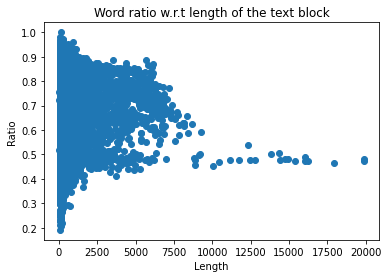

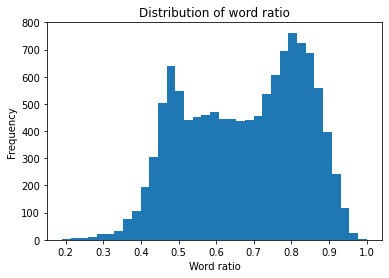

In [3]:
# reg = LinearRegression().fit(np.array(df["Length"]).reshape(-1,1), np.array(df["Ratio"]).reshape(-1,1))
# linevals = np.array(range(0,6582)).reshape(-1,1)
# pred = reg.predict(linevals)

plt.scatter(x = df["Length"], y = df["Ratio"])
# plt.plot( linevals, pred, c = "red")
plt.title("Word ratio w.r.t length of the text block")
plt.xlabel("Length")
plt.ylabel("Ratio")
plt.show()

plt.hist(x = df["Ratio"], bins = 35)
plt.title("Distribution of word ratio")
plt.xlabel("Word ratio")
plt.ylabel("Frequency")
plt.show()

In [ ]:
1870-1914